In [2]:
%load_ext autoreload
%autoreload 2

from pxr import Usd, UsdGeom
from matplotlib import pyplot as plt
from torch import Tensor

from scripts.view_animation_usd import apply_transform_homogeneous
from text3d2video.ipython_utils import view_pointcloud_orthographic

# Load USD file
usd_file = '/home/jorge/untitled.usdc'
stage = Usd.Stage.Open(usd_file)

In [3]:
for prim in stage.Traverse():
    print(prim.GetPath())

/root
/root/Armature
/root/Armature/Ch36
/root/Armature/Ch36/Mesh
/root/Camera
/root/Camera/Camera


In [4]:
frame_start = int(stage.GetStartTimeCode())
frame_end = int(stage.GetEndTimeCode())

frame = frame_start
xform_cache = UsdGeom.XformCache(time=frame)

In [5]:
for prim in stage.Traverse():
    if prim.IsA(UsdGeom.Mesh):
        mesh = UsdGeom.Mesh(prim)
    if prim.IsA(UsdGeom.Camera):
        camera = UsdGeom.Camera(prim)

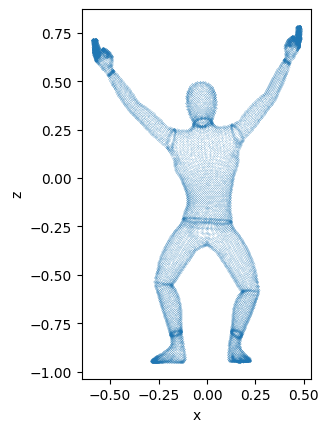

In [6]:
m2w = xform_cache.GetLocalToWorldTransform(mesh.GetPrim())
m2w = Tensor(m2w).T

verts = mesh.GetPointsAttr().Get()
face_indices = Tensor(mesh.GetFaceVertexIndicesAttr().Get()).int()
face_count = Tensor(mesh.GetFaceVertexCountsAttr().Get()).int()

verts = Tensor(mesh.GetPointsAttr().Get(frame))
verts_world = apply_transform_homogeneous(verts, m2w)

fig, ax = plt.subplots()
view_pointcloud_orthographic(ax, verts_world, horizontal_dim=0, vertical_dim=2)

In [7]:
blender_world_to_pt3d_world = Tensor([[-1, 0, 0], [0, 0, 1], [0, 1, 0]])
blender_cam_to_pt3d_cam = Tensor([[-1, 0, 0], [0, 1, 0], [0, 0, -1]])

In [9]:
verts_world_pt3d = verts_world @ blender_world_to_pt3d_world.T

In [10]:
from pytorch3d.structures import Meshes

from scripts.view_animation_usd import triangulate_usd_mesh

faces = triangulate_usd_mesh(face_count, face_indices)
mesh = Meshes(verts=[verts_world_pt3d], faces=[faces])

In [11]:
from scripts.view_animation_usd import decompose_transform_srt
from pytorch3d.renderer import FoVPerspectiveCameras

c2w = xform_cache.GetLocalToWorldTransform(camera.GetPrim())
c2w = Tensor(c2w).T

t, _, r = decompose_transform_srt(c2w)

In [12]:
import torch
from scripts.view_animation_usd import assemble_transform_srt


rp = blender_world_to_pt3d_world @ r @ blender_cam_to_pt3d_cam
tp = blender_world_to_pt3d_world @ t

c2w_pt3d = assemble_transform_srt(tp, torch.ones(3), rp)

In [13]:
w2c_pt3d = c2w_pt3d.inverse()
t_w2c, _, r_w2c = decompose_transform_srt(w2c_pt3d)

cam = FoVPerspectiveCameras(R=r_w2c.T.unsqueeze(0), T=t_w2c.unsqueeze(0), fov=40)

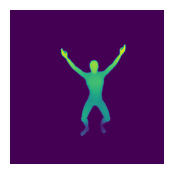

<Figure size 640x480 with 0 Axes>

In [14]:
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map


depths = render_depth_map(mesh.cuda(), cam.cuda())
display_ims(depths)